In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from scipy.stats import norm

from ase import Atoms
from ase.visualize import view

from tqdm import tqdm
from scipy.fft import fft

In [2]:
from scipy.interpolate import CubicSpline

def right_shift_dos(energies, dos, dE, evalEnergies):
    sp = CubicSpline(energies+dE, dos)
    sh_dos = sp(evalEnergies)
    sh_dos[evalEnergies < np.min(energies)+dE] = 0
    
    return sh_dos

# Atom Classes

In [3]:
from enum import Enum
from abc import ABC, abstractmethod
from dataclasses import dataclass
from collections.abc import Iterable
import scipy

def check_hermitian(a, rtol=1e-05, atol=1e-08):
    return scipy.linalg.ishermitian(a, atol=atol, rtol=rtol)

class Atom(ABC):
    def __init__(self, position, *args, **kwargs):
        self.position = position
    
    def get_position(self):
        return self.position
    
    @abstractmethod
    def get_n_orbitals(self):
        pass
    
    @abstractmethod
    def get_onsite(self):
        pass
    
    @abstractmethod
    def get_interaction(self, neighbor: 'Atom'):
        pass
    
    @abstractmethod
    def get_symbol(self):
        pass
        
        
class EndAtom(Atom):
    def get_n_orbitals(self):
        return 1
    
    def get_onsite(self):
        return np.array([1e10])
    
    def get_interaction(self, neighbor: Atom):
        return np.array([-1])
    
    def get_symbol(self):
        return 'H'
    
class CentralAtom(Atom):
    def __init__(self, position, equilibrium_spacing=5.431):
        self.position = position
        self.equilibrium_spacing = equilibrium_spacing
        
    def get_n_orbitals(self):
        return 1
    
    def get_onsite(self):
        return np.array([1])
    
    def get_interaction(self, neighbor: Atom):
        if neighbor.get_symbol() == 'H':
            return np.array([-1])
        elif neighbor.get_symbol() == 'Si':
            neighbor_dist = np.linalg.norm(neighbor.get_position() - self.get_position())
            
            # return np.array([-1 * (self.equilibrium_spacing/neighbor_dist)**2])
            return np.array([-1])
        else:
            raise NotImplementedError
    
    def get_symbol(self):
        return 'Si'

# 1D

In [4]:
def get_1d_hamiltonian(atoms):
    n_orbitals = atoms[0].get_n_orbitals()
    n_atoms = len(atoms)
    
    for atom in atoms:
        assert atom.get_n_orbitals() == n_orbitals
        
    int_size = n_atoms*n_orbitals
    hamiltonian = np.zeros((int_size, int_size))
    
    for i, atomi in enumerate(atoms):
        if i == 0:
            neighbors = [atoms[i], atoms[i+1]]
            delt = 0
        elif i == len(atoms) - 1:
            neighbors = [atoms[i-1], atoms[i]]
            delt = -1
        else:
            neighbors = [atoms[i-1], atoms[i], atoms[i+1]]
            delt = -1
        
        for ni, atomj in enumerate(neighbors):
            j = i + ni + delt
            if i == j:
                hamiltonian[i*n_orbitals:(i+1)*n_orbitals, 
                        j*n_orbitals:(j+1)*n_orbitals] = atomi.get_onsite()
            else:
                hamiltonian[i*n_orbitals:(i+1)*n_orbitals, 
                        j*n_orbitals:(j+1)*n_orbitals] = atomi.get_interaction(atomj)
            
    assert check_hermitian(hamiltonian)
    return hamiltonian

In [5]:
def get_atom_chain(N, hbondl=2.0, ias=3.0):
    # ias: Interatomic Spacing
    # hbondl: Bond length with hydrogen
    
    return [EndAtom(0)] + [CentralAtom(i*ias + hbondl) for i in range(N)] + [EndAtom((N-1)*ias + 2*hbondl)]

def create_atoms(atoms):
    atomstr = ''.join([atom.get_symbol() for atom in atoms])
    positions = [(atom.position, 0, 0) for atom in atoms]
    
    return Atoms(atomstr,
             positions=positions)
    
def visualize_chain(atoms):
    view(atoms)

def get_dos(energies, elow=-5, ehigh=5, broadening=0.5, npoints=200):
    evaluated = np.zeros((npoints,))
    points = np.linspace(elow, ehigh, npoints)
    
    for energy in energies:
        evaluated += norm.pdf(points, energy, broadening)
    
    return points, evaluated/len(energies)

## 1D Simulations

In [6]:
N = 6

hbondl = 2.0
ias = 3.0

atomChain = [EndAtom(0)] + [CentralAtom(i*ias + hbondl) for i in range(N)] + [EndAtom((N-1)*ias + 2*hbondl)]
hatomchain = get_1d_hamiltonian(atomChain)
vals5, vects5 = np.linalg.eigh(hatomchain)

aseatoms5 = create_atoms(atomChain)
# visualize_chain(aseatoms5)

print(hatomchain)

[[ 1.e+10 -1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00]
 [-1.e+00  1.e+00 -1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00]
 [ 0.e+00 -1.e+00  1.e+00 -1.e+00  0.e+00  0.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00 -1.e+00  1.e+00 -1.e+00  0.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00 -1.e+00  1.e+00 -1.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00  0.e+00 -1.e+00  1.e+00 -1.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -1.e+00  1.e+00 -1.e+00]
 [ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -1.e+00  1.e+10]]


In [ ]:
N = 5

hbondl = 2.0
ias = 3.0

atomChain = [EndAtom(0)] + [CentralAtom(i*ias + hbondl) for i in range(N)] + [EndAtom((N-1)*ias + 2*hbondl)]
hatomchain = get_1d_hamiltonian(atomChain)
vals5, vects5 = np.linalg.eigh(hatomchain)

aseatoms5 = create_atoms(atomChain)
#visualize_chain(aseatoms5)

In [13]:
N = 10

hbondl = 2.0
ias = 3.0

atomChain = [EndAtom(0)] + [CentralAtom(i*ias + hbondl) for i in range(N)] + [EndAtom((N-1)*ias + 2*hbondl)]
hatomchain = get_1d_hamiltonian(atomChain)
vals10, vects10 = np.linalg.eigh(hatomchain)

aseatoms10 = create_atoms(atomChain)
#visualize_chain(aseatoms10)

In [14]:
N = 7

hbondl = 2.0
ias = 3.0

atomChain = [EndAtom(0)] + [CentralAtom(i*ias + hbondl) for i in range(N)] + [EndAtom((N-1)*ias + 2*hbondl)]
hatomchain = get_1d_hamiltonian(atomChain)
vals15, vects15 = np.linalg.eigh(hatomchain)

aseatoms15 = create_atoms(atomChain)
#visualize_chain(aseatoms15)

In [15]:
N = 20

hbondl = 2.0
ias = 3.0

atomChain = [EndAtom(0)] + [CentralAtom(i*ias + hbondl) for i in range(N)] + [EndAtom((N-1)*ias + 2*hbondl)]
hatomchain = get_1d_hamiltonian(atomChain)
vals20, vects20 = np.linalg.eigh(hatomchain)

aseatoms20 = create_atoms(atomChain)
#visualize_chain(aseatoms20)

In [16]:
N = 50

hbondl = 2.0
ias = 3.0

atomChain = [EndAtom(0)] + [CentralAtom(i*ias + hbondl) for i in range(N)] + [EndAtom((N-1)*ias + 2*hbondl)]
hatomchain = get_1d_hamiltonian(atomChain)
vals50, vects50 = np.linalg.eigh(hatomchain)

aseatoms50 = create_atoms(atomChain)
#visualize_chain(aseatoms50)

In [17]:
N = 100

hbondl = 2.0
ias = 3.0

atomChain = [EndAtom(0)] + [CentralAtom(i*ias + hbondl) for i in range(N)] + [EndAtom((N-1)*ias + 2*hbondl)]
hatomchain = get_1d_hamiltonian(atomChain)
vals100, vects100 = np.linalg.eigh(hatomchain)

aseatoms100 = create_atoms(atomChain)
#visualize_chain(aseatoms100)

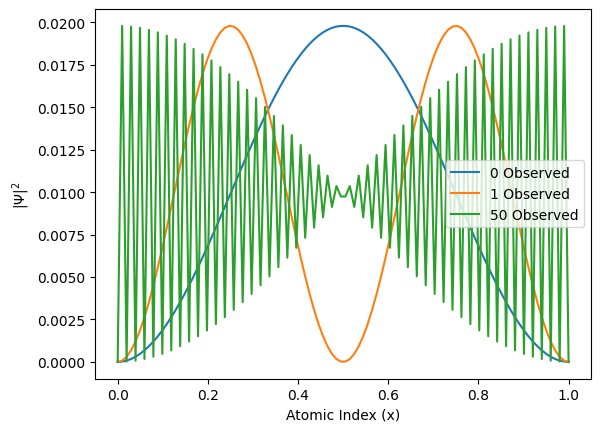

In [ ]:
plt.xlabel('Atomic Index (x)')
plt.ylabel('$|\Psi|^2$')
# for i in [-10]:
#     plt.plot(np.linspace(0,1,len(vects10[:, i])), vects10[:, i]**2/max(vects10[:, i]**2))
# for i in range(0,3):
# #     plt.plot(np.linspace(0,1,len(vects10[:, i])), vects10[:, i]**2/max(vects10[:, i]**2))
for i in [0, 1, 50]:
    plt.plot(np.linspace(0,1,len(vects100[:, i])), vects100[:, i] **2, label=f'{i} Observed')#/max(vects100[:, i]**2))
    plt.plot(np.linspace(0,1,len(vects100[:, i])), 
             np.sin((i + 1) * np.pi * np.linspace(0,1,len(vects100[:, i])))**2 * 2/(len(vects100[:, i])-1), label=f'{i} Theory', ls='--')
    
plt.legend()

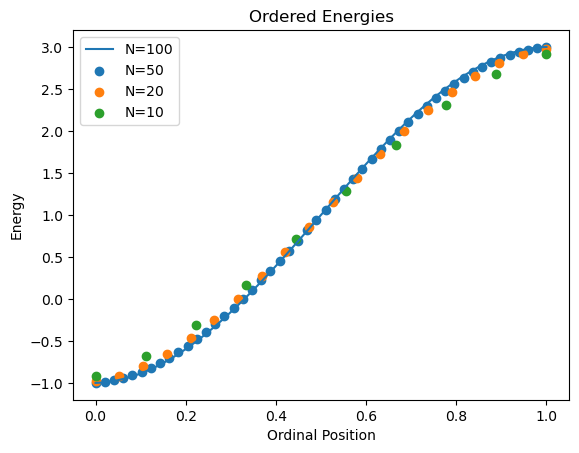

In [68]:
plt.figure()
plt.plot(np.linspace(0,1,len(vals100[:-2])), vals100[:-2], label='N=100')
plt.scatter(np.linspace(0,1,len(vals50[:-2])), vals50[:-2], label='N=50')
plt.scatter(np.linspace(0,1,len(vals20[:-2])), vals20[:-2], label='N=20')
plt.scatter(np.linspace(0,1,len(vals10[:-2])), vals10[:-2], label='N=10')

plt.title('Ordered Energies')
plt.ylabel('Energy')
plt.xlabel('Ordinal Position')

plt.legend()
plt.show()

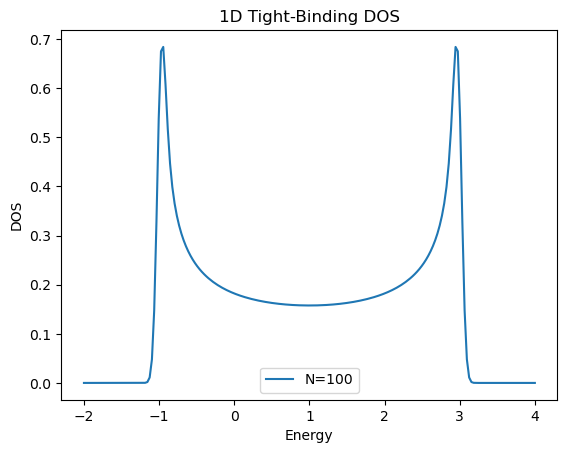

In [ ]:
# e, dos = get_dos(vals5, elow=-2, ehigh=4, broadening=0.5)
# plt.plot(e, dos, label='N=5')
# e, dos = get_dos(vals10, elow=-2, ehigh=4, broadening=0.5)
# plt.plot(e, dos, label='N=10')
# e, dos = get_dos(vals20, elow=-2, ehigh=4, broadening=0.5)
# plt.plot(e, dos, label='N=20')
# e, dos = get_dos(vals50, elow=-2, ehigh=4, broadening=0.5)
# plt.plot(e, dos, label='N=50')
e1, dos1 = get_dos(vals100, elow=-2, ehigh=4, broadening=0.05)
plt.plot(e1, dos1, label='N=100')
plt.xlabel('Energy')
plt.ylabel('DOS')
plt.title('1D Tight-Binding DOS')
plt.legend()
plt.show()

## Wavefunction Analysis

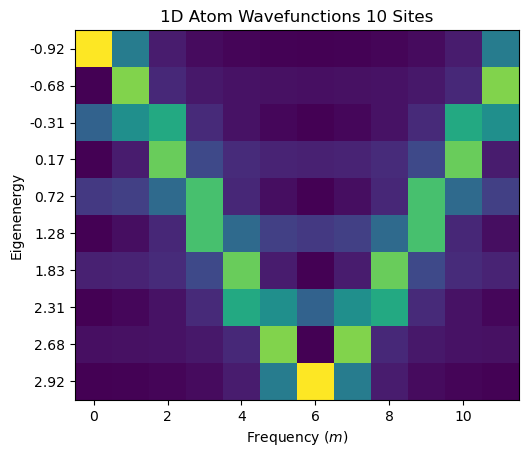

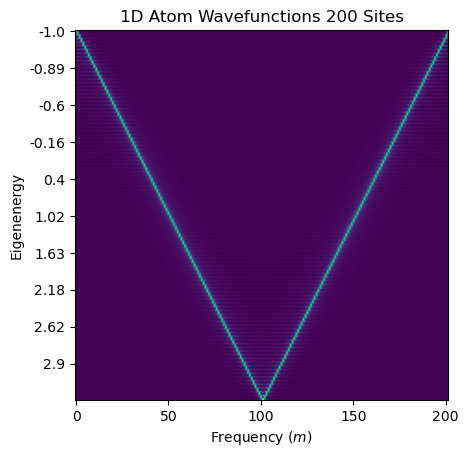

In [23]:
for i in [10, 200]:
    atomChain = get_atom_chain(i)
    hatomchain = get_1d_hamiltonian(atomChain)
    vals, vects = np.linalg.eigh(hatomchain)
    
    freqs = np.array([np.abs(fft(vects[:, i])) for i in range(len(vects[0])-2)])
    plt.figure()
    plt.title(f'1D Atom Wavefunctions {i} Sites')
    plt.xlabel('Frequency ($m$)')
    plt.ylabel('Eigenenergy')
    plt.yticks(np.arange(len(vals) - 2)[::len(vals)//10], [round(val, 2) for val in vals[:-2]][::len(vals)//10])
    plt.imshow(freqs)
    

# 2D

In [8]:
def get_chain_interaction(atoms):
    n_orbitals = atoms[0].get_n_orbitals()
    n_atoms = len(atoms)
    
    for atom in atoms:
        assert atom.get_n_orbitals() == n_orbitals
        
    int_size = n_atoms*n_orbitals
    hamiltonian = np.zeros((int_size, int_size))
    
    for i, atomi in enumerate(atoms):
        hamiltonian[i*n_orbitals:(i+1)*n_orbitals, 
                i*n_orbitals:(i+1)*n_orbitals] = atomi.get_interaction(atomi)
            
    assert check_hermitian(hamiltonian)
    return hamiltonian

def get_chain_interaction_cross_term(atoms, term_strength=1.0):
    n_orbitals = atoms[0].get_n_orbitals()
    n_atoms = len(atoms)
    
    for atom in atoms:
        assert atom.get_n_orbitals() == n_orbitals
        
    int_size = n_atoms*n_orbitals
    hamiltonian = np.zeros((int_size, int_size))
    
    for i, atomi in enumerate(atoms):
        hamiltonian[i*n_orbitals:(i+1)*n_orbitals, 
                i*n_orbitals:(i+1)*n_orbitals] = atomi.get_interaction(atomi)
        if i < len(atoms) - 1:
            hamiltonian[i*n_orbitals:(i+1)*n_orbitals, 
                (i+1)*n_orbitals:(i+2)*n_orbitals] = term_strength * atomi.get_interaction(atomi)
        if i > 0:
            hamiltonian[i*n_orbitals:(i+1)*n_orbitals, 
                (i-1)*n_orbitals:(i)*n_orbitals] = term_strength * atomi.get_interaction(atomi)
            
    assert check_hermitian(hamiltonian)
    return hamiltonian

def get_2d_hamiltonian(atoms, kx_frac):
    n_orbitals = atoms[0].get_n_orbitals()
    n_atoms = len(atoms)
    
    for atom in atoms:
        assert atom.get_n_orbitals() == n_orbitals
        
    int_size = n_atoms*n_orbitals
    
    H = get_1d_hamiltonian(atoms) + \
        np.exp(1j*kx_frac)*get_chain_interaction(atoms) + \
        np.exp(-1j*kx_frac)*get_chain_interaction(atoms)
            
    assert check_hermitian(H)
    return H

def get_2d_hamiltonian_cross(atoms, kx_frac, term_strength=1.0):
    n_orbitals = atoms[0].get_n_orbitals()
    n_atoms = len(atoms)
    
    for atom in atoms:
        assert atom.get_n_orbitals() == n_orbitals
        
    int_size = n_atoms*n_orbitals
    
    H = get_1d_hamiltonian(atoms) + \
        np.exp(1j*kx_frac)*get_chain_interaction_cross_term(atoms, term_strength=term_strength) + \
        np.exp(-1j*kx_frac)*get_chain_interaction_cross_term(atoms, term_strength=term_strength)
            
    assert check_hermitian(H)
    return H

  8%|████▎                                                 | 8/100 [00:03<00:40,  2.27it/s]
200it [01:10,  2.85it/s]                                                                   

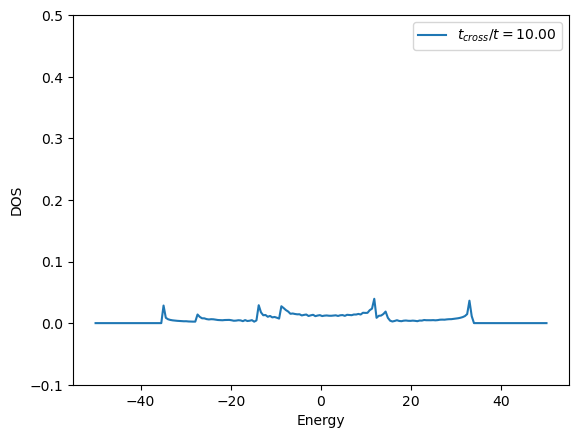

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from IPython.display import HTML

# Define your functions here

# Initialize plot
ias = hbondl = 3.0
N_layers = 4
fig, ax = plt.subplots()
line, = ax.plot([], [], label='Strength:')

def init():
    plt.title(f'{N_layers} Layer Cross-Linked')
    ax.set_xlabel('Energy')
    ax.set_ylabel('DOS')
    ax.legend()
    return line,

def update(frame):
    ax.clear()
    strength = frame
    atomChain = [EndAtom(0)] + [CentralAtom(i*ias + hbondl) for i in range(N_layers)] + [EndAtom((N_layers-1)*ias + 2*hbondl)]
    Nk = 1000
    kx_fracs = np.linspace(-np.pi, np.pi, Nk)
    evals = []
    
    for kx_frac in kx_fracs:
        evals += [np.linalg.eigh(get_2d_hamiltonian_cross(atomChain, kx_frac, term_strength=strength))[0]]

    e, dos = get_dos(np.array(evals).flatten(), elow=-50, 
                     ehigh=50, broadening=0.05)
    ax.plot(e, dos, label=f'$t_{{cross}}/t={strength:.2f}$')
    #ax.set_xlim(-4, 6)
    ax.set_ylim(-0.1, 0.5)
    ax.set_xlabel('Energy')
    ax.set_ylabel('DOS')
    ax.legend()
    pbar.update(1)
    return line,

N_frames = 100
pbar = tqdm(total=N_frames)
ani = FuncAnimation(fig, update, frames=np.linspace(0, 10, N_frames), init_func=init, blit=True)
ani.save(filename="/Users/krishnabhattaram/Desktop/Cross3.gif", writer="pillow")
HTML(ani.to_jshtml())

In [151]:
N = 5
atomChain = [EndAtom(0)] + [CentralAtom(i*ias + hbondl) for i in range(N)] + [EndAtom((N-1)*ias + 2*hbondl)]

Nk = 1000
kx_fracs = np.linspace(-np.pi, np.pi, Nk)
evals = []

for kx_frac in tqdm(kx_fracs):
    evals += [np.linalg.eigh(get_2d_hamiltonian_cross(atomChain, kx_frac, 10))[0]]


100%|████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2622.34it/s]


(-50.0, 50.0)

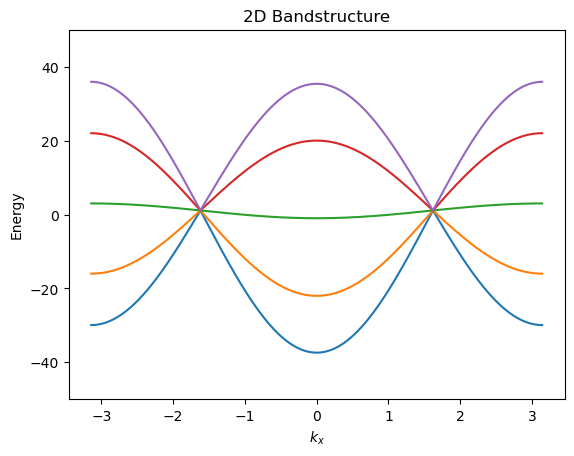

In [152]:
plt.plot(kx_fracs, np.array(evals))
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.title('2D Bandstructure')

plt.ylim((-50, 50))

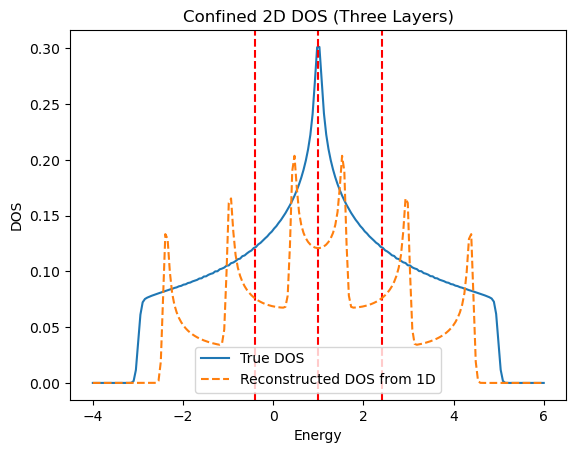

In [122]:
e, dos = get_dos(np.array(evals).flatten(), elow=-4, ehigh=6, broadening=0.05)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.plot(e, dos,label='True DOS')
plt.axvline(x=1-2*1*np.cos(1*np.pi/4), ls='--', c='r')
plt.axvline(x=1-2*1*np.cos(2*np.pi/4), ls='--', c='r')
plt.axvline(x=1-2*1*np.cos(3*np.pi/4), ls='--', c='r')
plt.title('Confined 2D DOS (Three Layers)')

plt.plot(e, (right_shift_dos(e1, dos1, 1-2*1*np.cos(1*np.pi/4)-1, e) + \
         right_shift_dos(e1, dos1, 1-2*1*np.cos(2*np.pi/4)-1, e) + \
         right_shift_dos(e1, dos1, 1-2*1*np.cos(3*np.pi/4)-1, e))/5, ls='--', label='Reconstructed DOS from 1D')
plt.legend()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 27529.99it/s]


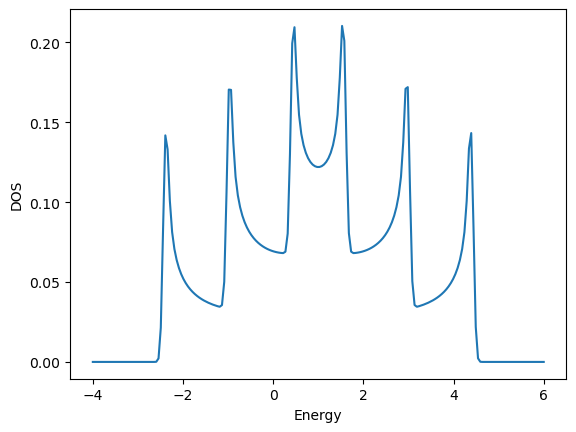

In [30]:
e2d, dos2d = get_dos(np.array(evals).flatten(), elow=-4, ehigh=6, broadening=0.05)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.plot(e2d, dos2d,label='True DOS')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.64it/s]


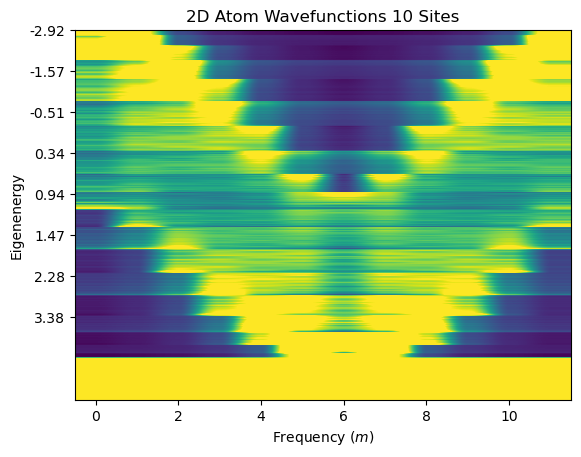

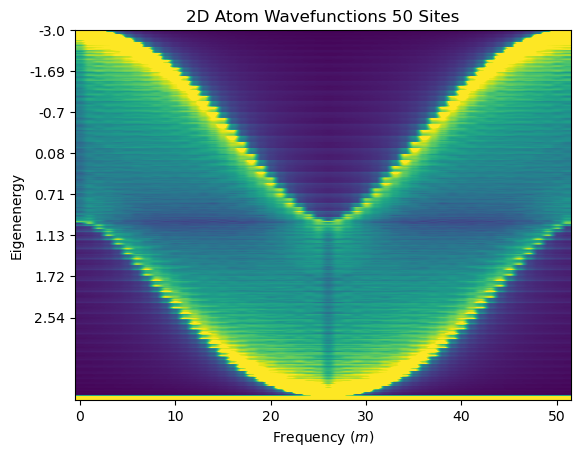

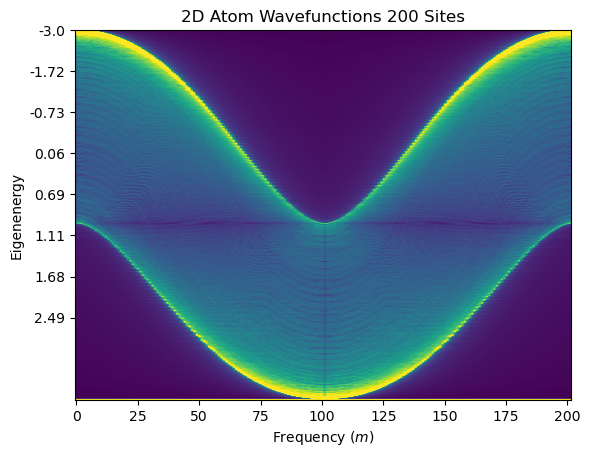

In [31]:
for i in [10, 50, 200]:
    atomChain = get_atom_chain(i)
    
    Nk = 1000
    kx_fracs = np.linspace(-np.pi, np.pi, Nk)
    evals2d = np.empty((Nk, len(atomChain)))
    ewav = {},

    for x, kx_frac in enumerate(tqdm(kx_fracs)):
        evals2d[x, :], wav = np.linalg.eigh(get_2d_hamiltonian(atomChain, kx_frac))
        for e, wavf in zip(np.array(evals2d[x, :]), wav.T):
            ewav[e] = wavf
    
    energies, wavefunctions = np.array(list(ewav.keys())), np.array(list(ewav.values()))
    freqs = np.array([np.abs(fft(wavefunctions[i])) for i in range(len(wavefunctions))])

    indices = np.argsort(energies)

    plt.figure()
    plt.title(f'2D Atom Wavefunctions {i} Sites')
    plt.xlabel('Frequency ($m$)')
    plt.ylabel('Eigenenergy')
    plt.yticks(np.arange(len(energies))[::len(energies)//9][:-2], [round(energy, 2) for energy in energies[indices]][::len(energies)//9][:-2])
    plt.imshow(freqs[indices, :], aspect='auto', vmax=1)
    

# 3D

In [141]:
def get_3d_hamiltonian(atoms, kx_frac, ky_frac):
    n_orbitals = atoms[0].get_n_orbitals()
    n_atoms = len(atoms)
    
    for atom in atoms:
        assert atom.get_n_orbitals() == n_orbitals
        
    int_size = n_atoms*n_orbitals
    
    H = get_1d_hamiltonian(atoms) + \
        np.exp(1j*kx_frac)*get_chain_interaction(atoms) + \
        np.exp(-1j*kx_frac)*get_chain_interaction(atoms)+ \
        np.exp(1j*ky_frac)*get_chain_interaction(atoms) + \
        np.exp(-1j*ky_frac)*get_chain_interaction(atoms)
            
    assert check_hermitian(H)
    return H

def get_3d_hamiltonian_cross(atoms, kx_frac, ky_frac, term_strength=0.0):
    n_orbitals = atoms[0].get_n_orbitals()
    n_atoms = len(atoms)
    
    for atom in atoms:
        assert atom.get_n_orbitals() == n_orbitals
        
    int_size = n_atoms*n_orbitals
    
    H = get_1d_hamiltonian(atoms) + \
        np.exp(1j*kx_frac)*get_chain_interaction_cross_term(atoms, term_strength=term_strength) + \
        np.exp(-1j*kx_frac)*get_chain_interaction_cross_term(atoms, term_strength=term_strength)+ \
        np.exp(1j*ky_frac)*get_chain_interaction_cross_term(atoms, term_strength=term_strength) + \
        np.exp(-1j*ky_frac)*get_chain_interaction_cross_term(atoms, term_strength=term_strength)
            
    assert check_hermitian(H)
    return H

  6%|███▏                                                  | 6/100 [00:06<01:49,  1.16s/it]
200it [03:09,  1.06it/s]                                                                   

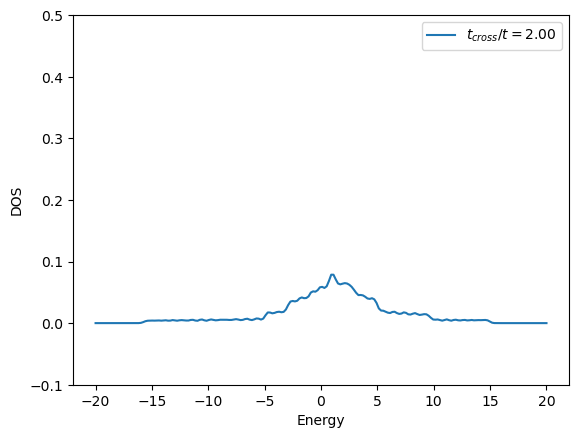

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from IPython.display import HTML

# Define your functions here

# Initialize plot
N_layers = 3
fig, ax = plt.subplots()
line, = ax.plot([], [], label='Strength:')

def init():
    plt.title(f'{N_layers} Layer Cross-Linked')
    ax.set_xlabel('Energy')
    ax.set_ylabel('DOS')
    ax.legend()
    return line,

def update(frame):
    ax.clear()
    strength = frame
    
    atomChain = [EndAtom(0)] + [CentralAtom(i*ias + hbondl) for i in range(N_layers)] + [EndAtom((N_layers-1)*ias + 2*hbondl)]
    Nk = 50
    kx_fracs = np.linspace(-np.pi, np.pi, Nk)
    evals = []
    
    kx_fracs = np.linspace(-np.pi, np.pi, Nk)
    ky_fracs = np.linspace(-np.pi, np.pi, Nk)

    evals3d = np.empty((Nk, Nk, len(atomChain)))

    for x, kx_frac in enumerate(kx_fracs):
        for y, ky_frac in enumerate(ky_fracs):
            evals3d[x, y, :], wav = np.linalg.eigh(get_3d_hamiltonian_cross(atomChain, kx_frac, ky_frac, 
                                                                            term_strength=strength))

    e, dos = get_dos(np.array(evals3d).flatten(), elow=-20, ehigh=20, broadening=0.2)

    ax.plot(e, dos, label=f'$t_{{cross}}/t={strength:.2f}$')
    #ax.set_xlim(-4, 6)
    ax.set_ylim(-0.1, 0.5)
    ax.set_xlabel('Energy')
    ax.set_ylabel('DOS')
    ax.legend()
    
    pbar.update(1)
    return line,

N_frames = 100
pbar = tqdm(total=N_frames)
ani = FuncAnimation(fig, update, frames=np.linspace(0, 2, N_frames), init_func=init, blit=True)
ani.save(filename="/Users/krishnabhattaram/Desktop/3dCross3.gif", writer="pillow")
HTML(ani.to_jshtml())

In [406]:
N = 3
Nk = 100

atomChain = [EndAtom(0)] + [CentralAtom(i*ias + hbondl) for i in range(N)] + [EndAtom((N-1)*ias + 2*hbondl)]

kx_fracs = np.linspace(-np.pi, np.pi, Nk)
ky_fracs = np.linspace(-np.pi, np.pi, Nk)

evals3d = np.empty((Nk, Nk, len(atomChain)))
ewav = {}

for x, kx_frac in enumerate(tqdm(kx_fracs)):
    for y, ky_frac in enumerate(ky_fracs):
        evals3d[x, y, :], wav = np.linalg.eigh(get_3d_hamiltonian(atomChain, kx_frac, ky_frac))
        for e, wavf in zip(np.array(evals3d[x, y, :]), wav):
            ewav[e] = wavf

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.59it/s]


/var/folders/l8/phwmh2vd6x9c79s99l16zs140000gp/T/ipykernel_2224/3833406879.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs.scatter(X, Y, evals3d[:, :, 0], cmap='viridis', edgecolor='none')


Text(0.5, 0.92, '3D Bandstructure')

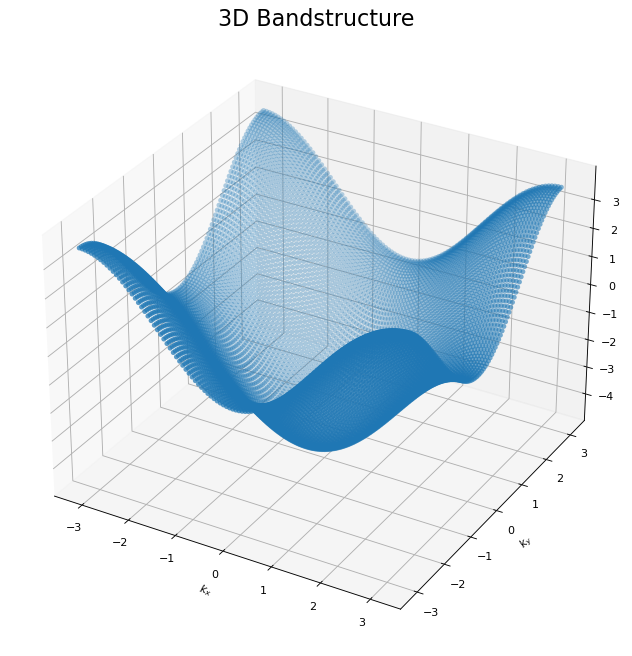

In [408]:
X, Y = np.meshgrid(kx_fracs, ky_fracs)
plt.figure(figsize=(10, 10), dpi=80)
axs = plt.axes(projection='3d')
axs.scatter(X, Y, evals3d[:, :, 0], cmap='viridis', edgecolor='none')
#axs.scatter(X, Y, evals3d[:, :, 1], cmap='viridis', edgecolor='none')
#axs.scatter(X, Y, evals3d[:, :, 2], cmap='viridis', edgecolor='none')
#axs.scatter(X, Y, evals3d[:, :, 30], cmap='viridis', edgecolor='none')
axs.set_xlabel('$k_x$')
axs.set_ylabel('$k_y$')
axs.set_zlabel('Energy', fontsize=5, rotation=60)
axs.set_title('3D Bandstructure', fontsize=20)



In [409]:
e, dos = get_dos(np.array(evals3d).flatten(), elow=-6, ehigh=8, broadening=0.1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:02<00:00, 19030.82it/s]


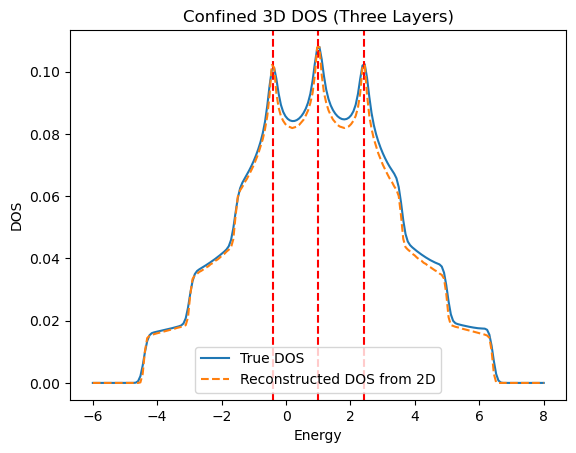

In [413]:
plt.plot(e, dos, label='True DOS')
plt.axvline(x=1-2*1*np.cos(1*np.pi/4), ls='--', c='r')
plt.axvline(x=1-2*1*np.cos(2*np.pi/4), ls='--', c='r')
plt.axvline(x=1-2*1*np.cos(3*np.pi/4), ls='--', c='r')
plt.xlabel('Energy')
plt.ylabel('DOS')
plt.title('Confined 3D DOS (Three Layers)')

plt.plot(e, (right_shift_dos(e2d, dos2d, 1-2*1*np.cos(1*np.pi/4)-1, e) + \
         right_shift_dos(e2d, dos2d, 1-2*1*np.cos(2*np.pi/4)-1, e) + \
         right_shift_dos(e2d, dos2d, 1-2*1*np.cos(3*np.pi/4)-1, e))/5, ls='--', label='Reconstructed DOS from 2D')
plt.legend()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


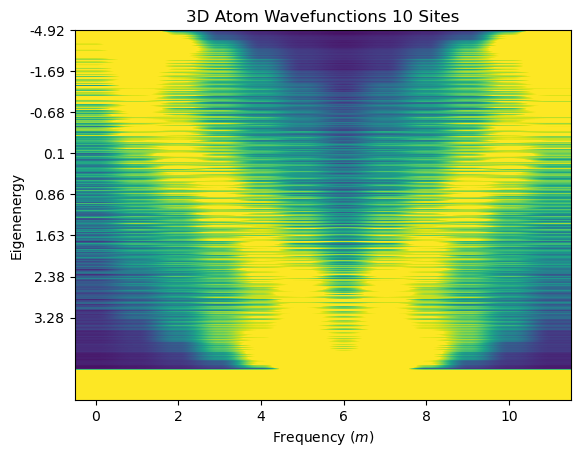

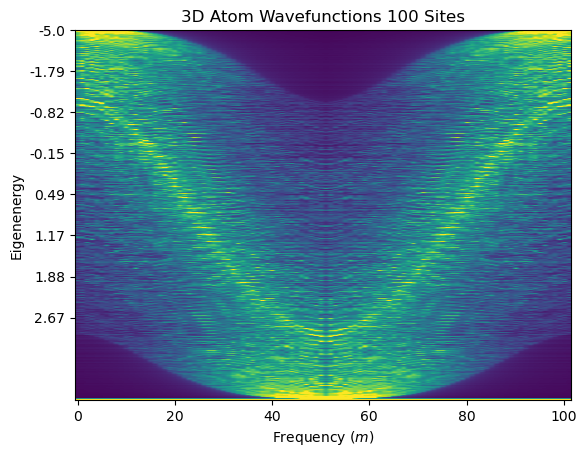

In [465]:
for i in [10, 100]:
    atomChain = get_atom_chain(i)
    
    Nk = 100
    kx_fracs = np.linspace(-np.pi, np.pi, Nk)
    ky_fracs = np.linspace(-np.pi, np.pi, Nk)

    evals3d = np.empty((Nk, Nk, len(atomChain)))
    ewav = {}

    for x, kx_frac in enumerate(tqdm(kx_fracs)):
        for y, ky_frac in enumerate(ky_fracs):
            evals3d[x, y, :], wav = np.linalg.eigh(get_3d_hamiltonian(atomChain, kx_frac, ky_frac))
            for e, wavf in zip(np.array(evals3d[x, y, :]), wav.T):
                ewav[e] = wavf
                
    energies, wavefunctions = np.array(list(ewav.keys())), np.array(list(ewav.values()))
    freqs = np.array([np.abs(fft(wavefunctions[i])) for i in range(len(wavefunctions))])

    indices = np.argsort(energies)

    plt.figure()
    plt.title(f'3D Atom Wavefunctions {i} Sites')
    plt.xlabel('Frequency ($m$)')
    plt.ylabel('Eigenenergy')
    plt.yticks(np.arange(len(energies))[::len(energies)//9][:-2], [round(energy, 2) for energy in energies[indices]][::len(energies)//9][:-2])
    plt.imshow(freqs[indices, :], aspect='auto', vmax=0.9)
    

# More Orbitals

In [142]:
class EndAtom2o(Atom):
    def get_n_orbitals(self):
        return 2
    
    def get_onsite(self):
        return np.array([[1e10, 0], [0, 1e10]])
    
    def get_interaction(self, neighbor: Atom):
        return np.array([[-1, 0],[0, -1]])
    
    def get_symbol(self):
        return 'H'
    
class CentralAtom2o(Atom):
    def __init__(self, position, equilibrium_spacing=5.431):
        self.position = position
        self.equilibrium_spacing = equilibrium_spacing
        
    def get_n_orbitals(self):
        return 2
    
    def get_onsite(self):
        return np.array([[7, 0],[0, -5]])
    
    def get_interaction(self, neighbor: Atom):
        if neighbor.get_symbol() == 'H':
            return np.array([[-1, 0],[0, -1]])
        elif neighbor.get_symbol() == 'Si':
            neighbor_dist = np.linalg.norm(neighbor.get_position() - self.get_position())
            
            # return np.array([-1 * (self.equilibrium_spacing/neighbor_dist)**2])
            return np.array([[1, 2],[2, -1]])
        else:
            raise NotImplementedError
    
    def get_symbol(self):
        return 'Si'
    
def get_atom_chain2o(N, hbondl=2.0, ias=3.0):
    # ias: Interatomic Spacing
    # hbondl: Bond length with hydrogen
    
    return [EndAtom2o(0)] + [CentralAtom2o(i*ias + hbondl) for i in range(N)] + [EndAtom2o((N-1)*ias + 2*hbondl)]


In [143]:
vals32o, vects32o = np.linalg.eigh(get_1d_hamiltonian(get_atom_chain2o(3)))

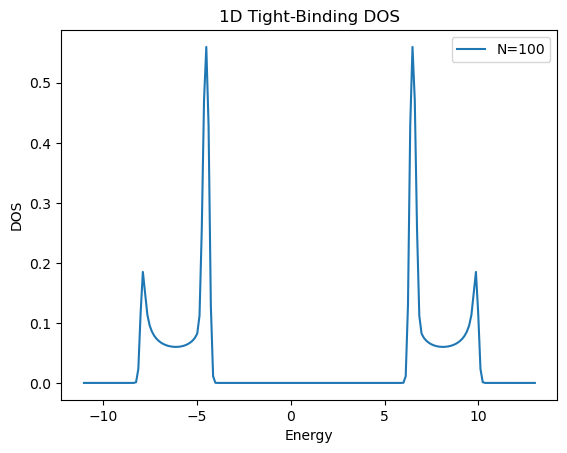

In [144]:
vals1002o, vects1002o = np.linalg.eigh(get_1d_hamiltonian(get_atom_chain2o(100)))
e1d, dos1d = get_dos(vals1002o, elow=-11, ehigh=13, broadening=0.1)

plt.plot(e1d, dos1d, label='N=100')
plt.xlabel('Energy')
plt.ylabel('DOS')
plt.title('1D Tight-Binding DOS')
plt.legend()
plt.show()


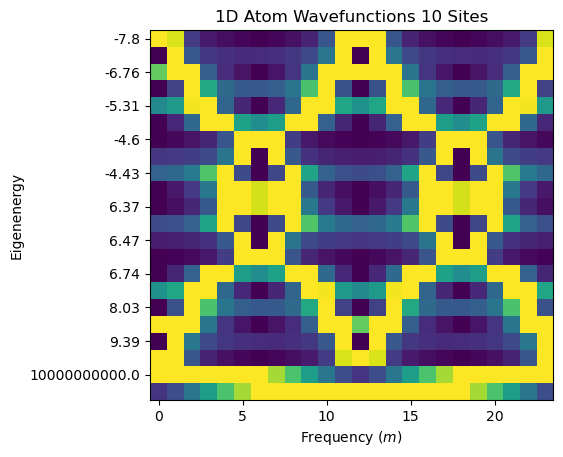

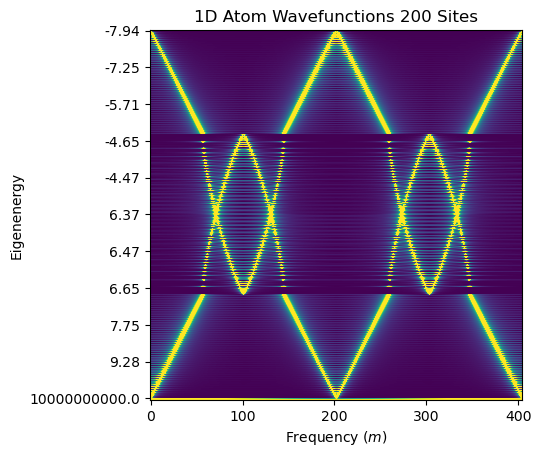

In [715]:
for i in [10, 200]:
    atomChain = get_atom_chain2o(i)
    hatomchain = get_1d_hamiltonian(atomChain)
    vals, vects = np.linalg.eigh(hatomchain)
    
    freqs = np.array([np.abs(fft(vects[:, i])) for i in range(len(vects[0])-2)])
    plt.figure()
    plt.title(f'1D Atom Wavefunctions {i} Sites')
    plt.xlabel('Frequency ($m$)')
    plt.ylabel('Eigenenergy')
    plt.yticks(np.arange(len(vals) -2)[::len(vals)//10], [round(val, 2) for val in vals[:-2]][::len(vals)//10])
    plt.imshow(freqs, vmax=1)
    

# 2D

In [716]:
print(get_chain_interaction(get_atom_chain2o(2)))

[[-1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  2.  0.  0.  0.  0.]
 [ 0.  0.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  2.  0.  0.]
 [ 0.  0.  0.  0.  2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.]]


In [145]:
N = 3
atomChain = get_atom_chain2o(N)

Nk = 2000
kx_fracs = np.linspace(-np.pi, np.pi, Nk)
evals = []

for kx_frac in tqdm(kx_fracs):
    evals += [np.linalg.eigh(get_2d_hamiltonian(atomChain, kx_frac))[0]]


100%|████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 5035.77it/s]


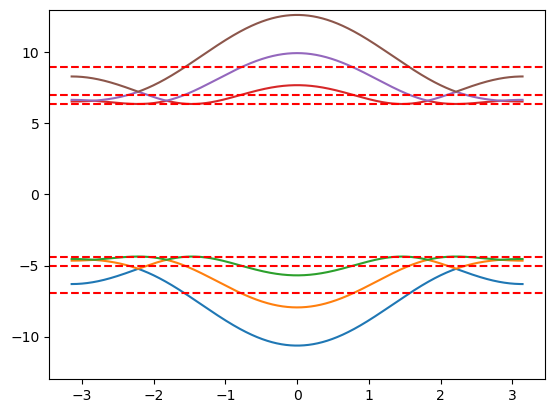

In [146]:
plt.plot(kx_fracs, np.array(evals))
plt.ylim((-13, 13))
for val in np.linalg.eigh(get_1d_hamiltonian(get_atom_chain2o(N)))[0]:
    plt.axhline(y=val, ls='--', c='r')

In [147]:
e2d, dos2d = get_dos(np.array(evals).flatten(), elow=-13, ehigh=13, broadening=0.02)

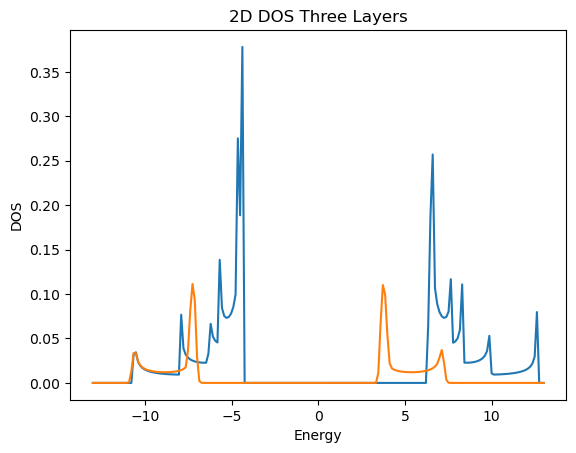

In [148]:
plt.figure()
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.plot(e2d, dos2d, label=f'N={N}')
# plt.axvline(x=vals32o[0]-2, ls='--', c='r')
# plt.axvline(x=vals32o[1]-2, ls='--', c='r')
# plt.axvline(x=vals32o[2]-2, ls='--', c='r')
# plt.axvline(x=vals32o[3]-2, ls='--', c='r')
# plt.axvline(x=vals32o[4]-2, ls='--', c='r')
# plt.axvline(x=vals32o[5]-2, ls='--', c='r')
plt.plot(e2d, (right_shift_dos(e1d, dos1d, vals32o[0]+4.2, e2d))/5)
plt.title('2D DOS Three Layers')
plt.show()

# 3D

In [643]:
N = 3
Nk = 300

atomChain = get_atom_chain2o(N)

kx_fracs = np.linspace(-np.pi, np.pi, Nk)
ky_fracs = np.linspace(-np.pi, np.pi, Nk)

evals3d = np.empty((Nk, Nk, len(atomChain*2)))
ewav = {}

for x, kx_frac in enumerate(tqdm(kx_fracs)):
    for y, ky_frac in enumerate(ky_fracs):
        evals3d[x, y, :], wav = np.linalg.eigh(get_3d_hamiltonian(atomChain, kx_frac, ky_frac))
        for e, wavf in zip(np.array(evals3d[x, y, :]), wav):
            ewav[e] = wavf

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:25<00:00, 11.90it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 900000/900000 [00:42<00:00, 21198.75it/s]


Text(0.5, 1.0, '3D DOS')

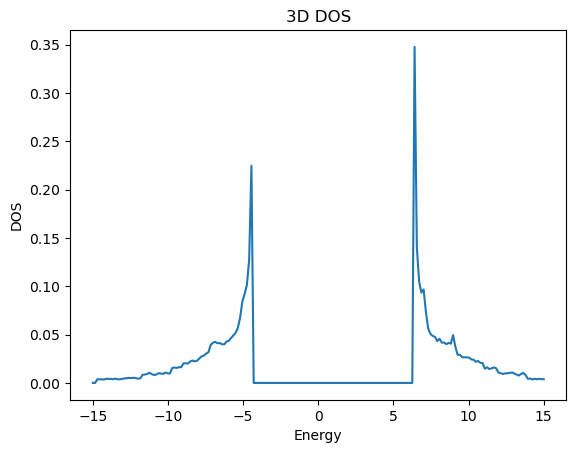

In [644]:
e, dos = get_dos(np.array(evals3d).flatten(), elow=-15, ehigh=15, broadening=0.01)
plt.plot(e, dos, label='N=3')
# plt.axvline(x=1-2*1*np.cos(1*np.pi/4)-4, ls='--', c='r')
# plt.axvline(x=1-2*1*np.cos(2*np.pi/4)-4, ls='--', c='r')
# plt.axvline(x=1-2*1*np.cos(3*np.pi/4)-4, ls='--', c='r')
plt.xlabel('Energy')
plt.ylabel('DOS')
plt.title('3D DOS')